In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline
tf.config.set_visible_devices([], 'GPU')

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
print(len(train_df.landmark_id.unique()))
print(train_df.landmark_id.max())
print(train_df.landmark_id.min())

81313
203092
1


In [4]:
train_df.landmark_id.value_counts().loc[train_df.landmark_id.value_counts() > 1000]

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
177870    1088
194914    1073
Name: landmark_id, dtype: int64

In [5]:
train_df.landmark_id.value_counts().loc[train_df.landmark_id.value_counts() < 100]

47401     99
53058     99
63473     99
29537     99
1236      99
          ..
180503     2
179834     2
183115     2
63266      2
197219     2
Name: landmark_id, Length: 79298, dtype: int64

In [6]:
train_df.landmark_id.value_counts().loc[train_df.landmark_id.value_counts() < 50]

46004     49
172504    49
186365    49
47561     49
106147    49
          ..
180503     2
179834     2
183115     2
63266      2
197219     2
Name: landmark_id, Length: 74812, dtype: int64

In [7]:
train_df.landmark_id.value_counts().loc[train_df.landmark_id.value_counts() < 10]

126088    9
55962     9
188816    9
184726    9
120733    9
         ..
180503    2
179834    2
183115    2
63266     2
197219    2
Name: landmark_id, Length: 41637, dtype: int64

In [8]:
landmark_id_sample_list = [126637, 113209, 194914, 47401, 1236, 180503, 63266, 197219, 83144, 47561, 106147, 188816, 126088]

In [9]:
train_df.loc[train_df.landmark_id == 139894].id

1091057    000e5acba361de91
1091058    00750ba2629ccdb0
1091059    00c3f7049c308d6a
1091060    00cf1af7a2f1a940
1091061    00e20546ace5995a
                 ...       
1092018    ff44a11735e9a3cd
1092019    ff4a9abb53fd9051
1092020    ff56ab96130562ec
1092021    ff69adb1c3cef547
1092022    fffbc91a7cf038cc
Name: id, Length: 966, dtype: object

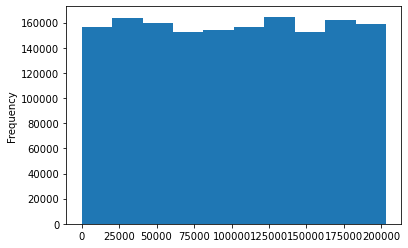

In [10]:
train_df.landmark_id.plot(kind='hist')

In [11]:
train_df.loc[train_df.id == '0000ae056149919f']

,id,landmark_id
995306,0000ae056149919f,128432


In [12]:
for filename in os.listdir('train/0/0/0'):
    print(os.path.splitext(filename)[0])

0000059611c7d079
000014b1f770f640
000015f76534add3
00001ae42cd00356
00001b2ba2c69ac5
000020dfc079c013
000022ce0b9d8966
0000341f232b1354
00003fe2469cdbf5
00004208e2bc0cc0
000054af45275b62
00005f617bc1763e
00007594d1b97325
0000ae056149919f
0000c60a968c6b92
0000c8cb9f609e7a
0000d0c3babeeffb
0000e69998d37a98
0000fb2148d6c0e4
0000fc82f5f2440a
0000ffd8771d66ef
000102e1aec36f2b
00010dc0bc0f9417
000117ac0efec994
00011ae297e4ea48
00011e1543c80df7
0001264e556fadde
0001291c85c5cee4
0001389ccab5118a
00014028389a81fc
000155148d9f0948
000171b259e48280
0001741076b61475
00017bd0410c6016
000189419c9e44e6
00018c9815dc97d5
00018d7947a2a33f
00019b859b575233
00019baa6474c394
00019f1e3920ae0c
0001a926735b74de
0001aa145a185bd5
0001ab4127e84977
0001b7ba0106b4d6
0001c405b87f8abe
0001cca2408230f5
0001cd1dc5ec2d37
0001cea5d2ae9494
0001d150ba3697f6
0001dbf4734f4eb1
0001dc06ea03b5bd
0001e062bddb9179
0001f99980a1d29a
00021006542cf5d4
00021be1ce5ab8c3
0002214e4407b9c0
0002272575ca2b45
00022c4a6a1bb331
00022df18f970b

In [13]:
def load_images_from_folder(folder, image_size=(250, 250)):
    images = []
    for filename in os.listdir(folder):
        loaded_img = load_img(os.path.join(folder,filename), target_size=image_size)
        numpy_img = img_to_array(loaded_img)
        images.append((os.path.splitext(filename)[0], numpy_img))
    return images

In [14]:
def load_image_from_file(filepath, image_size=(250, 250)):
    loaded_img = load_img(filepath, target_size=image_size)
    numpy_img = img_to_array(loaded_img)
    return (os.path.splitext(filename)[0], numpy_img)

In [15]:
input_img_dim = (250, 250, 3)
img_size = (250, 250)

In [16]:
# train_img_list = []
# train_img_data_list = []
# sample_dirs = ['0', '5', 'a', 'f']
# base_dir = 'train'
# for sub_dir_1 in sample_dirs:
#     for sub_dir_2 in sample_dirs:
#         for sub_dir_3 in sample_dirs:
#             current_dir = os.path.join(base_dir, sub_dir_1, sub_dir_2, sub_dir_3)
#             train_img_list.extend(load_images_from_folder(current_dir, image_size=img_size))

In [17]:
train_img_list = []
base_dir = 'train'

for land_id in landmark_id_sample_list:
    filename_list = list(train_df.loc[(train_df.landmark_id == land_id)].id)
    for filename in filename_list:
        filename = filename + '.jpg'
        filepath = os.path.join(base_dir, filename[0], filename[1], filename[2], filename)
        train_img_list.append(load_image_from_file(filepath, image_size=img_size))
    

In [18]:
train_img_df = pd.DataFrame(train_img_list, columns=['id', 'image_data'])

In [19]:
train_img_df = pd.merge(train_img_df, train_df, on='id', how='left')
train_img_df['categorized_landmark_id'] = train_img_df.landmark_id.astype('category').cat.codes
num_ids = len(train_img_df.categorized_landmark_id.unique())
print(num_ids)

13


In [20]:
image_data = np.array(train_img_df.image_data.to_list())
target_labels = train_img_df.categorized_landmark_id

In [21]:
# train_img_df = pd.merge(train_img_df, train_df, on='id', how='left')
# landmark_bins = list(range(0, train_df.landmark_id.max(), 40000))
# landmark_bins.append(np.inf)
# bins = [*range(0, len(landmark_bins) - 1)]
# train_img_df['landmark_id_bin'] = pd.cut(
#     train_img_df.landmark_id,
#     landmark_bins,
#     labels=bins
# ).astype('int')

# num_ids = len(train_img_df.landmark_id_bin.unique())
# print(num_ids)

In [22]:
# image_data = np.array(train_img_df.image_data.to_list())
# target_labels = train_img_df.landmark_id_bin

In [23]:
train_img_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       6500 non-null   object
 1   image_data               6500 non-null   object
 2   landmark_id              6500 non-null   int64 
 3   categorized_landmark_id  6500 non-null   int8  
dtypes: int64(1), int8(1), object(2)
memory usage: 209.5+ KB


In [40]:
train_img_df.head()

,id,image_data,landmark_id,categorized_landmark_id
0,000b0d1da1f48a3f,"[[[189.0, 187.0, 130.0], [198.0, 191.0, 137.0]...",126637,8
1,0014ed3f568a680e,"[[[147.0, 155.0, 168.0], [147.0, 155.0, 168.0]...",126637,8
2,0024d95487eb0cb1,"[[[202.0, 198.0, 195.0], [153.0, 149.0, 146.0]...",126637,8
3,0053c9bc80c2001c,"[[[122.0, 140.0, 160.0], [122.0, 140.0, 160.0]...",126637,8
4,00762370abaf613a,"[[[8.0, 9.0, 14.0], [9.0, 10.0, 15.0], [10.0, ...",126637,8


In [24]:
image_data.shape

(6500, 250, 250, 3)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_data, target_labels, test_size=0.25, random_state=42)

In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sca = tf.keras.metrics.SparseCategoricalAccuracy()

base_model = tf.keras.applications.VGG19(input_shape=input_img_dim, include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1000, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(num_ids, activation='softmax')
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    dropout_layer,
    prediction_layer
])
model.compile(optimizer=adam, loss=scce, metrics=[sca])

In [27]:
es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

model.fit(X_train, y_train, batch_size=1, epochs=2, validation_data=(X_val, y_val), callbacks=[es], use_multiprocessing=1)
# ba = tf.keras.metrics.BinaryAccuracy()
# recall = tf.keras.metrics.Recall()
# precision = tf.keras.metrics.Precision()
# ba.update_state(y_test, model.predict(X_test))
# recall.update_state(y_test, [prediction[0] for prediction in model.predict(X_test)])
# precision.update_state(y_test, [prediction[0] for prediction in model.predict(X_test)])
# recall_result = recall.result().numpy()
# precision_result = precision.result().numpy()

# network_type = 'VGG19'
# print(network_type, '-', 'accuracy:', ba.result().numpy())
# print(network_type, '-', 'recall:', recall_result)
# print(network_type, '-', 'precision:', precision_result)
# print(network_type, '-', 'F1 score:', 2 * (precision_result * recall_result) / (precision_result + recall_result))

Train on 4875 samples, validate on 1625 samples
Epoch 1/2
4875/4875 [==============================] - 786s 161ms/sample - loss: 1.9507 - sparse_categorical_accuracy: 0.7399 - val_loss: 1.9118 - val_sparse_categorical_accuracy: 0.7772
Epoch 2/2
4875/4875 [==============================] - 804s 165ms/sample - loss: 1.9237 - sparse_categorical_accuracy: 0.7655 - val_loss: 1.9158 - val_sparse_categorical_accuracy: 0.7729


In [28]:
base_dir = 'test'
test_img_list = []
for sub_dir_1 in os.listdir(base_dir):
    for sub_dir_2 in os.listdir(os.path.join(base_dir, sub_dir_1)):
        for sub_dir_3 in os.listdir(os.path.join(base_dir, sub_dir_1, sub_dir_2)):
            for filename in os.listdir(os.path.join(base_dir, sub_dir_1, sub_dir_2, sub_dir_3)):
                test_img_list.append(load_image_from_file(os.path.join(base_dir, sub_dir_1, sub_dir_2, sub_dir_3, filename), image_size=img_size))
        

In [29]:
test_img_df = pd.DataFrame(test_img_list, columns=['id', 'image_data'])
image_data = np.array(test_img_df.image_data.to_list())

In [30]:
predictions = model.predict(image_data)

In [31]:
test_img_df.iloc[0].id

'00084cdf8f600d00'

In [44]:
landmark_id_sample_list.sort()
landmark_id_sample_list

[1236,
 47401,
 47561,
 63266,
 83144,
 106147,
 113209,
 126088,
 126637,
 180503,
 188816,
 194914,
 197219]

In [47]:
train_df.loc[train_df.landmark_id == 83144].id

,id,landmark_id
646636,000d9bf37257daff,83144
646637,003381eb803c7328,83144
646638,00353a6000f2bdcb,83144
646639,004cf6a4880f4d12,83144
646640,0053cdc62c02139b,83144
...,...,...
648372,ffacab2ececa36d0,83144
648373,ffbcc5745b09b39f,83144
648374,ffeff6310977fa9d,83144
648375,fff43ef827e34410,83144


In [48]:
for index, prediction in enumerate(predictions):
    max_value = np.max(prediction)
    max_index = np.where(prediction == max_value)[0][0]
    print(test_img_df.iloc[index].id, max_value, landmark_id_sample_list[max_index])

00084cdf8f600d00 0.8648534 126637
00141b8a5a729084 1.0 126637
0044d82ea7654ece 0.9836624 126637
00d5b448fa93e1b8 0.9999995 126637
012436be7f659057 1.0 126637
013098904123b014 1.0 126637
01b4c4975d1bebbe 1.0 126637
027a19e10127d5c4 0.99998283 83144
0289a20454afe4d2 1.0 126637
02cb34a8dc4030da 1.0 126637
03182100f70cf0cf 0.9999999 126637
031e0db4ab66a433 0.9974057 126637
0359a8986a260937 0.99999917 126637
036d00223b10d021 0.9999999 126637
0389bc4066eb452f 1.0 126637
03b1294a0fa46763 1.0 126637
044fae46d25c3705 1.0 126637
04ab9004b863898f 0.9954993 126637
04b5907da759ef3f 1.0 126637
0523f94fb3ee2724 1.0 126637
055dcb35370f00e9 0.99667954 113209
063f875880dd09c5 1.0 126637
068950f9fdb1145c 0.9999995 126637
06af43630be43790 0.99999964 83144
06d240c7cf8be3b8 1.0 126637
077117ab2a19d998 1.0 126637
0776cfb823a90bd8 1.0 126637
07aa275a89f85b5b 0.99959654 126637
09032988bde9e0b2 1.0 126637
09350dd2a24acc46 0.99999547 126637
095402386b2d5bf3 1.0 126637
09777418eb3c6c5c 0.9993994 126637
0978cf3481

b64e9d7737f525c0 0.99468225 126637
b664dae002e91b13 1.0 126637
b68ad17173806184 1.0 126637
b68bc67e21f0b691 0.98514056 83144
b6958a93159b8164 1.0 126637
b6d7d1a91e12fbc4 0.9998956 126637
b7063befbcc3028f 1.0 126637
b72f13bb334cdca7 1.0 126637
b7632103d53422c4 0.6341376 83144
b77148ca4062c037 1.0 126637
b7edd872ae7ed202 0.99999666 126637
b831a55d487de41d 0.97993565 83144
b835933bc9ecacce 1.0 126637
b84bc7facfed1826 1.0 126637
b86e66455361a1f7 1.0 83144
b886b207c88ebf71 1.0 126637
b9104af77a39afec 0.9999981 126637
b9374139bd30817f 1.0 126637
b977a2b5b85e8a69 0.9964709 126637
b979431aafc0b7d2 0.9997687 126637
b9bb07dd9d362de8 0.85537213 83144
b9f4e63a1ae8cf33 1.0 126637
ba4052696828b076 0.99999976 126637
ba40f0963c8aa559 1.0 126637
ba4c871a55313fbc 0.9999615 83144
ba7d7bc5d51a9f10 0.9999999 126637
bb49a00066fad441 0.9697546 126637
bb55392cdb8f096b 1.0 126637
bb59232ac04865fa 0.99964774 83144
bb7bbc579e95d82f 1.0 126637
bcd606af2662652b 1.0 126637
bd0fa2953983a116 1.0 126637
bd1ab77699961e